In [1]:
from glob import glob
import re
import numpy as np
import pandas as pd
import collections
from datetime import datetime
from matplotlib import pylab, pyplot

In [2]:
%matplotlib inline

In [3]:
def linux_and_cyr_font_fix():
    prms = pylab.rcParams
    for k in prms:
        if k.startswith('font.') and isinstance(prms[k], collections.Iterable):
            for f in {f for f in prms[k] if f.startswith('Bitstream Vera ')}:
                prms[k].remove(f)
            print k, prms[k]
linux_and_cyr_font_fix()

font.fantasy [u'Comic Sans MS', u'Chicago', u'Charcoal', u'ImpactWestern', u'Humor Sans', u'fantasy']
font.serif [u'DejaVu Serif', u'New Century Schoolbook', u'Century Schoolbook L', u'Utopia', u'ITC Bookman', u'Bookman', u'Nimbus Roman No9 L', u'Times New Roman', u'Times', u'Palatino', u'Charter', u'serif']
font.stretch normal
font.cursive [u'Apple Chancery', u'Textile', u'Zapf Chancery', u'Sand', u'Script MT', u'Felipa', u'cursive']
font.variant normal
font.style normal
font.family [u'sans-serif']
font.sans-serif [u'DejaVu Sans', u'Lucida Grande', u'Verdana', u'Geneva', u'Lucid', u'Arial', u'Helvetica', u'Avant Garde', u'sans-serif']
font.weight normal
font.monospace [u'DejaVu Sans Mono', u'Andale Mono', u'Nimbus Mono L', u'Courier New', u'Courier', u'Fixed', u'Terminal', u'monospace']


In [4]:
def stats():
    uptime_re = re.compile('\n' r'uptime (\d+)' '\n')
    bandwidth_re = re.compile('\n' r'bandwidth 1073741824 1073741824 (\d+)' '\n')
    published_re = re.compile('\n' r'published (\d+-\d+-\d+ \d+:\d+:\d+)' '\n')
    ip_re = re.compile('router kaction ([0-9.]+) 9001 0 ')
    df = {'uptime': [], 'bandwidth': [], 'published': [], 'ip': []}
    for fname in  glob('server/[0-9a-f]*[0-9a-f]'):
        with open(fname) as fd:
            blob = fd.read()
        # TODO: check signature?
        assert '\nfingerprint 2402 CD5A 0D84 8D1D CA61 EB70 8CC1 FBD4 364A B8AE\n' in blob
        assert '\ncontact 0x54B7F00D Dmitry Bogatov <KAction /at/ gnu /dot/ org>\n' in blob
        df['uptime'].append(int(uptime_re.search(blob).group(1)))
        df['bandwidth'].append(int(bandwidth_re.search(blob).group(1)))
        df['published'].append(published_re.search(blob).group(1))
        df['ip'].append(ip_re.search(blob).group(1))
    df = pd.DataFrame(df)
    df['published'] = pd.to_datetime(df['published'])
    return df.sort_values('published')
df = stats()

Время указано в UTC, ровно так же, как и в опубликованных файлах.

In [5]:
df.head()

,bandwidth,ip,published,uptime
122,7293417,46.188.10.23,2017-01-01 10:10:07,265119
86,7293417,46.188.10.23,2017-01-02 04:10:38,329956
57,7026048,46.188.10.23,2017-01-02 09:40:09,349727
71,7530774,46.188.10.23,2017-01-03 03:40:47,414572
74,7530496,46.188.10.23,2017-01-03 17:24:09,0


In [6]:
df.tail()

,bandwidth,ip,published,uptime
193,5843077,46.188.56.136,2017-04-03 09:40:27,187463
83,5842944,46.188.56.136,2017-04-03 20:38:09,0
99,5842944,46.188.56.136,2017-04-03 20:38:11,1
85,6503739,46.188.56.136,2017-04-04 14:38:58,64858
45,6503739,46.188.56.136,2017-04-05 08:39:42,129703


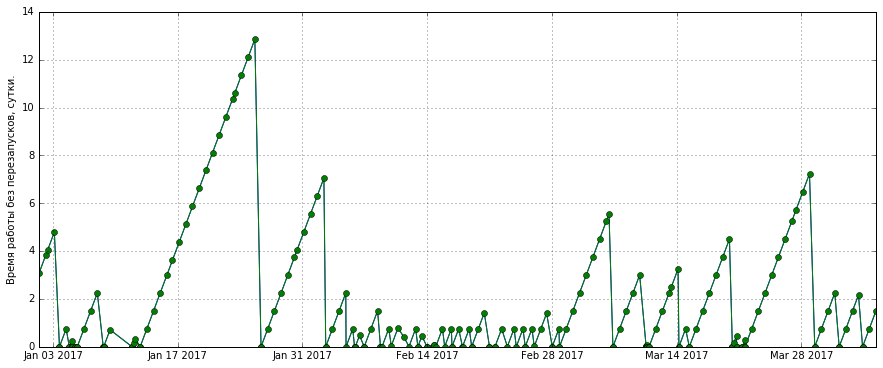

In [7]:
pyplot.figure(figsize=(15, 6))
pyplot.plot(df.published, df.uptime / 86400.)
pyplot.plot(df.published, df.uptime / 86400., marker='o')
pyplot.ylabel(u'Время работы без перезапусков, сутки.')
pyplot.grid()

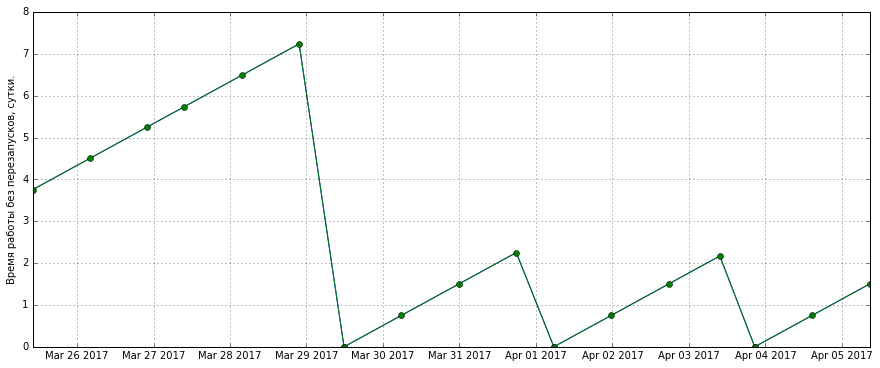

In [8]:
sample = df[df.published > '2017-03-25']
pyplot.figure(figsize=(15, 6))
pyplot.plot(sample.published, sample.uptime / 86400.)
pyplot.plot(sample.published, sample.uptime / 86400., marker='o')
pyplot.ylabel(u'Время работы без перезапусков, сутки.')
pyplot.grid()

In [9]:
df[(df.published > '2017-03-28') & (df.published < '2017-04-01')]

,bandwidth,ip,published,uptime
140,6179437,46.188.56.136,2017-03-28 03:41:22,560581
52,5691617,46.188.56.136,2017-03-28 21:41:31,625397
69,7302144,46.188.56.136,2017-03-29 11:46:33,0
47,7302144,46.188.56.136,2017-03-29 11:46:35,0
160,7302144,46.188.56.136,2017-03-30 05:47:26,64859
130,6196293,46.188.56.136,2017-03-30 23:48:18,129713
55,6203141,46.188.56.136,2017-03-31 17:48:35,194531


Т.е. действительно 29 марта в 14:46 по Москве узел Tor перезапускался. 

In [10]:
def extras():
    read_re = re.compile('\n' r'read-history (\d+-\d+-\d+ \d+:\d+:\d+) \(14400 s\) (\d+,\d+,\d+,\d+,\d+,\d+)' '\n')
    write_re = re.compile('\n' r'write-history (\d+-\d+-\d+ \d+:\d+:\d+) \(14400 s\) (\d+,\d+,\d+,\d+,\d+,\d+)' '\n')
    published_re = re.compile('\n' r'published (\d+-\d+-\d+ \d+:\d+:\d+)' '\n')
    df = {'read': [], 'write': [], 'ts': [], 'published': []}
    for fname in  glob('extra/[0-9a-f]*[0-9a-f]'):
        with open(fname) as fd:
            blob = fd.read()
        # TODO: check signature?
        assert '\nextra-info kaction 2402CD5A0D848D1DCA61EB708CC1FBD4364AB8AE\n' in blob
        published = pd.to_datetime(published_re.search(blob).group(1))
        read_ts, read = read_re.search(blob).groups()
        write_ts, write = write_re.search(blob).groups()
        read = reversed(map(int, read.split(',')))
        write = reversed(map(int, write.split(',')))
        assert read_ts == write_ts
        read_ts = pd.to_datetime(read_ts)
        for r, w in zip(read, write):
            df['published'].append(published)
            df['read'].append(r)
            df['write'].append(w)
            df['ts'].append(read_ts)
            read_ts -= pd.Timedelta(seconds=14400) # TODO: should it be done BEFORE or AFTER appending?
    df = pd.DataFrame(df)
    return df.sort_values('ts')
ex = extras()

In [11]:
ex.head(10)

,published,read,ts,write
77,2017-01-01 10:10:07,39869149184,2016-12-31 13:39:29,40150895616
76,2017-01-01 10:10:07,46239034368,2016-12-31 17:39:29,46498682880
75,2017-01-01 10:10:07,38635678720,2016-12-31 21:39:29,39118370816
74,2017-01-01 10:10:07,34166645760,2017-01-01 01:39:29,34740000768
73,2017-01-01 10:10:07,34673671168,2017-01-01 05:39:29,35173052416
119,2017-01-02 04:10:38,34673671168,2017-01-01 05:39:29,35173052416
72,2017-01-01 10:10:07,42435988480,2017-01-01 09:39:29,43258060800
118,2017-01-02 04:10:38,42435988480,2017-01-01 09:39:29,43258060800
401,2017-01-02 09:40:09,52008136704,2017-01-01 13:39:29,52948118528
117,2017-01-02 04:10:38,52008136704,2017-01-01 13:39:29,52948118528


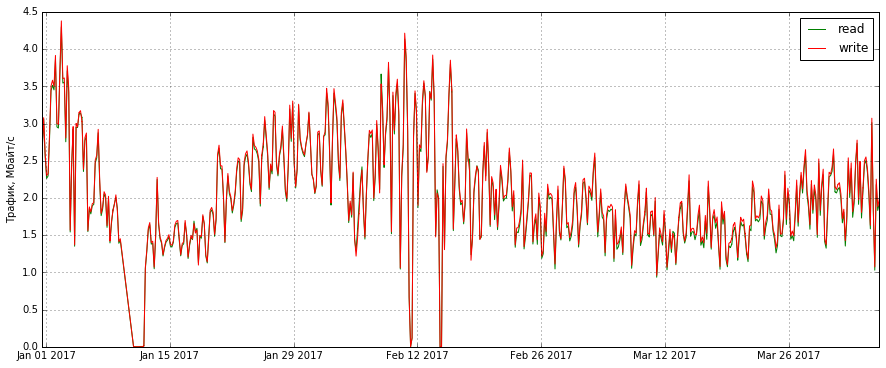

In [12]:
NUM_SECS_BW_SUM_INTERVAL = 4*60*60
pyplot.figure(figsize=(15, 6))
pyplot.ylabel(u'Трафик, Мбайт/с')
pyplot.plot(ex.ts, ex.read / NUM_SECS_BW_SUM_INTERVAL / 1024**2, color='green', label='read')
pyplot.plot(ex.ts, ex.write / NUM_SECS_BW_SUM_INTERVAL / 1024**2, color='red', label='write')
pyplot.legend()
pyplot.grid()

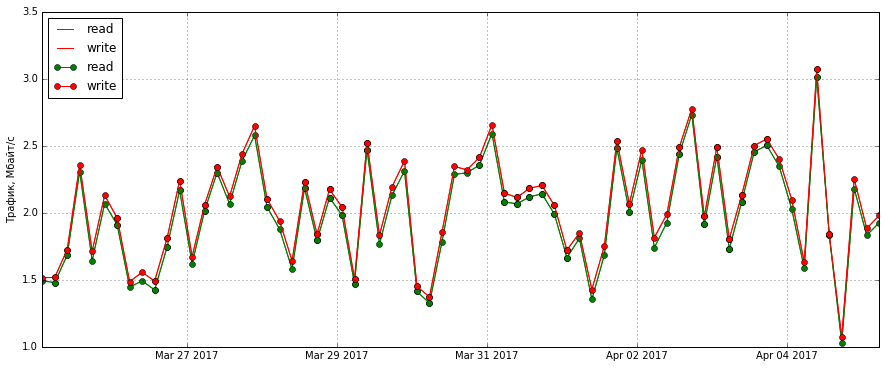

In [13]:
sample = ex[ex.ts > '2017-03-25']
pyplot.figure(figsize=(15, 6))
pyplot.ylabel(u'Трафик, Мбайт/с')
pyplot.plot(sample.ts, sample.read / NUM_SECS_BW_SUM_INTERVAL / 1024**2, color='green', label='read')
pyplot.plot(sample.ts, sample.write / NUM_SECS_BW_SUM_INTERVAL / 1024**2, color='red', label='write')
pyplot.plot(sample.ts, sample.read / NUM_SECS_BW_SUM_INTERVAL / 1024**2, color='green', marker='o')
pyplot.plot(sample.ts, sample.write / NUM_SECS_BW_SUM_INTERVAL / 1024**2, color='red', marker='o')
pyplot.legend(loc='upper left')
pyplot.grid()